# **Training a spiking neural network on a simple vision dataset**

In Tutorial 1 we have seen how to train a simple multi-layer spiking neural network (SNN) on a small synthetic dataset using both a true gradient and a surrogate gradient. In this tutorial, we will train such network using the surrogate gradient for the classification of a slightly larger dataset. Concretely, we will use the [Fashion MNIST dataset](https://github.com/zalandoresearch/fashion-mnist).

In [1]:
import os
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import torch
import torch.nn as nn
import torchvision
from tqdm import tqdm

Use GPU if possible!

In [2]:
def get_torch_device(verbose: bool = True):
  if torch.cuda.is_available():  # Print additional info when using cuda
      device = torch.device('cuda:0')
      current_dev = torch.cuda.current_device()
      cap_dev = torch.cuda.get_device_capability()
      if verbose:
        print(f'\nRunning on GPU {torch.cuda.get_device_name(device)} '
              f'(compute capability {cap_dev[0]}.{cap_dev[1]}) '
              f'number {current_dev + 1} of {torch.cuda.device_count()}\n'
              f'Total memory:     {round(torch.cuda.get_device_properties(current_dev).total_memory / 1024 ** 2, 1)} MB\n'
              f'Allocated memory: {round(torch.cuda.memory_allocated(current_dev) / 1024 ** 2, 1)} MB\n'
              f'Cached memory:    {round(torch.cuda.memory_reserved(current_dev) / 1024 ** 2, 1)} MB\n')
  else:
      device = torch.device('cpu')
      if verbose:
        print('\nRunning on CPU.\n')
  return device

dtype = torch.float
device = get_torch_device()


Running on GPU Tesla T4 (compute capability 7.5) number 1 of 1
Total memory:     15109.8 MB
Allocated memory: 0.0 MB
Cached memory:    0.0 MB



Set a random seed for all stochastic computations.

In [3]:
seed = 12
np.random.seed(seed)
torch.manual_seed(seed)

## Define all main parameters

**Initialize network parameters**: number of neurons in each layer.

We will use a simple feedforward multilayer network model with a single hidden layer, as in the previous tutorial.

Since the images in the Fashion MNIST dataset have shape 28x28 and 10 possible classes, we set these values for the number of neurons in the input and readout layers. In the hidden layer, we will use 100 neurons, but such value is somehow arbitrary.

In [4]:
nb_pixels = 28
nb_inputs = nb_pixels * nb_pixels
nb_hidden = 100
nb_outputs = 10

Set a weight scale for weights initialization (if you with, otherwise leave it to None). Be carefull if you change this value: make sure that the given weight scale will give us some spikes to begin with.

In [5]:
weight_scale = None

**Initialize simulation parameters**: time of the simulation.

As we have seen, we are technically simulating an RNN. Thus we have to simulate our neurons for a certain number of timesteps. We will use 1ms time step, and we want to simulate our network for say 100 timesteps.

In [6]:
time_step = 1e-3
nb_steps = 100

**Initialize training parameters**: number of epochs, learning rate and batch size.

In [7]:
nb_epochs = 10
lr = 2e-4

To take advantage of parallelism, we will set up our code to work on batches of data like this is usually done for neural networks that are trained in a supervised manner.
To that end, we specify a batch size here.

In [8]:
batch_size = 256

**Initialize LIF-neuron parameters**: synaptic and membrane time constants.

In [9]:
tau_mem = 10e-3
tau_syn = 5e-3

With these basic design choices made, we can now start building the actual network. Here we will be using PyTorch, but you will be able to reproduce these results in most common machine learning libraries.

## Load the Fashion MNIST dataset

In [10]:
root = os.path.expanduser("../data/fashion-mnist")
train_dataset = torchvision.datasets.FashionMNIST(root, train=True,
                                                  download=True)
test_dataset = torchvision.datasets.FashionMNIST(root, train=False,
                                                 download=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/fashion-mnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/fashion-mnist/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/fashion-mnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/fashion-mnist/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/fashion-mnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/fashion-mnist/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/fashion-mnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/fashion-mnist/FashionMNIST/raw



Standardize data.

In [11]:
x_train = np.array(train_dataset.data, dtype=np.float)
x_train = x_train.reshape(x_train.shape[0], -1) / 255
# x_train = torch.tensor(train_dataset.data, device=device, dtype=dtype)

y_train = np.array(train_dataset.targets, dtype=np.int)
# y_train = torch.tensor(train_dataset.targets, device=device, dtype=dtype)

x_test = np.array(test_dataset.data, dtype=np.float)
x_test = x_test.reshape(x_test.shape[0], -1) / 255
# x_test = torch.tensor(test_dataset.data, device=device, dtype=dtype)

y_test = np.array(test_dataset.targets, dtype=np.int)
# y_test  = torch.tensor(test_dataset.targets, device=device, dtype=dtype)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/dev

Plot one of the raw data points as an example.

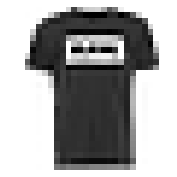

In [12]:
data_id = 1
plt.figure(figsize=(3, 3))
plt.imshow(x_train[data_id].reshape(nb_pixels, nb_pixels), cmap=plt.cm.gray_r)
plt.axis("off")
plt.show()

## Convert images to Spiking data

Since we are working with spiking neural networks, we ideally want to use a temporal code to make use of spike timing.
To that end, we will use a spike latency code to feed spikes to our network.

In [13]:
def current2firing_time(x, tau=20., thr=0.2, tmax=1.0, epsilon=1e-7):
    """ Computes first firing time latency for a current input x assuming the charge time of a current based LIF neuron.

    Args:
    x -- The "current" values

    Keyword args:
    tau -- The membrane time constant of the LIF neuron to be charged
    thr -- The firing threshold value
    tmax -- The maximum time returned
    epsilon -- A generic (small) epsilon > 0

    Returns:
    Time to first spike for each "current" x
    """
    idx = x < thr
    x = np.clip(x, thr + epsilon, 1e9)
    T = tau * np.log(x / (x - thr))
    T[idx] = tmax
    return T

## Setup of the spiking network model

#### The spiking nonlinearity

In order to compute the spikes in the SNN we must first define its spiking nonlinearity function. Here we will use a Heaviside step function (in the forward pass) but with a different "surrogate" gradient (for the backward pass).

In [14]:
class SurrGradSpike(torch.autograd.Function):
    """
    Here we implement our spiking nonlinearity which also implements
    the surrogate gradient. By subclassing torch.autograd.Function,
    we will be able to use all of PyTorch's autograd functionality.
    Here we use the normalized negative part of a fast sigmoid
    as this was done in Zenke & Ganguli (2018).
    """

    scale = 100.0  # controls steepness of surrogate gradient

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we compute a step function of the input Tensor
        and return it. ctx is a context object that we use to stash information which
        we need to later backpropagate our error signals. To achieve this we use the
        ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor we need to compute the
        surrogate gradient of the loss with respect to the input.
        Here we use the normalized negative part of a fast sigmoid
        as this was done in Zenke & Ganguli (2018).
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input / (SurrGradSpike.scale * torch.abs(input) + 1.0) ** 2
        return grad

#### The whole network

Now is the time to build the infrastructure for simulating and training our spiking neural network (in discrete time). The SNN we use is made of an input layer (the data), a hidden layer and a readout layer. We will only use feedforward connections, but recurrence can be introduced with slight changes to the following code.

In [15]:
class SNN:
    def __init__(self,
                 time_step=1e-3, nb_steps=200, batch_size=256,
                 nb_inputs=100, nb_hidden=4, nb_outputs=2,
                 tau_mem=10e-3, tau_syn=5e-3, weight_scale=None,
                 verbose=True, use_gpu=True, dtype=None, device=None, seed=None):
        # Initialize torch parameters
        self.verbose = verbose
        self._dtype = torch.float if dtype is None else dtype
        self._device = (self._init_gpu() if use_gpu else torch.device('cpu')) if device is None else device
        self._seed = seed
        if self._seed is not None:
            torch.manual_seed(self._seed)
        # Initialize simulation parameters
        self._dt = time_step
        self.nb_ts = nb_steps
        # Initialize network parameters
        self.nb_in = nb_inputs
        self.nb_hid = nb_hidden
        self.nb_out = nb_outputs
        self.batch_sz = batch_size
        # Initialize LIF-neuron parameters
        self._tau_mem = tau_mem
        self._tau_syn = tau_syn
        self._alpha = float(np.exp(-self._dt / self._tau_syn))
        self._beta = float(np.exp(-self._dt / self._tau_mem))
        # Define activation function
        self._spike_fn = SurrGradSpike.apply
        # Initialize weights
        self.weight_scale = 7 * (1.0 - self._beta) if weight_scale is None \
            else weight_scale  # make sure the given weight scale will give us some spikes to begin with
        self._w1, self._w2 = self.init_weights()

    @property
    def seed(self):
        return self._seed

    @seed.setter
    def seed(self, new_value):
        self._seed = new_value
        if self._seed is not None:
            torch.manual_seed(self._seed)

    @property
    def tau_mem(self):
        return self._tau_mem

    @tau_mem.setter
    def tau_mem(self, new_value):
        self._tau_mem = new_value
        self._beta = float(np.exp(-self._dt / self._tau_mem))

    @property
    def tau_syn(self):
        return self._tau_syn

    @tau_syn.setter
    def tau_syn(self, new_value):
        self._tau_syn = new_value
        self._alpha = float(np.exp(-self._dt / self._tau_syn))

    @property
    def time_step(self):
        return self._dt

    @time_step.setter
    def time_step(self, new_value):
        self._dt = new_value
        self._alpha = float(np.exp(-self._dt / self._tau_syn))
        self._beta = float(np.exp(-self._dt / self._tau_mem))

    @property
    def weights(self):
        return [np.copy(self._w1.cpu().detach().numpy()),
                np.copy(self._w2.cpu().detach().numpy())]

    def _init_gpu(self):
        # Use GPU if possible!
        return get_torch_device(self.verbose)
      
    def init_weights(self):
        # Feedforward weights
        w_1 = torch.empty((self.nb_in, self.nb_hid), device=self._device, dtype=self._dtype, requires_grad=True)
        torch.nn.init.normal_(w_1, mean=0.0, std=self.weight_scale / np.sqrt(self.nb_in))
        w_2 = torch.empty((self.nb_hid, self.nb_out), device=self._device, dtype=self._dtype, requires_grad=True)
        torch.nn.init.normal_(w_2, mean=0.0, std=self.weight_scale / np.sqrt(self.nb_hid))
        return w_1, w_2

    def sparse_data_generator(self, X, y, shuffle=True):
        """ This generator takes datasets in analog format and generates spiking network input as sparse tensors.

        Args:
            X: The data ( sample x event x 2 ) the last dim holds (time,neuron) tuples
            y: The labels
        """

        labels_ = np.array(y, dtype=np.int)
        number_of_batches = len(X) // self.batch_sz
        sample_index = np.arange(len(X))

        # compute discrete firing times
        tau_eff = 20e-3 / self._dt
        firing_times = np.array(current2firing_time(X, tau=tau_eff, tmax=self.nb_ts), dtype=np.int)
        unit_numbers = np.arange(self.nb_in)

        if shuffle:
            np.random.shuffle(sample_index)

        counter = 0
        while counter < number_of_batches:
            batch_index = sample_index[self.batch_sz * counter: self.batch_sz * (counter + 1)]

            coo = [[], [], []]
            for bc, idx in enumerate(batch_index):
                c = firing_times[idx] < self.nb_ts
                times, units = firing_times[idx][c], unit_numbers[c]

                batch = [bc for _ in range(len(times))]
                coo[0].extend(batch)
                coo[1].extend(times)
                coo[2].extend(units)

            i = torch.LongTensor(coo).to(self._device)
            v = torch.FloatTensor(np.ones(len(coo[0]))).to(self._device)

            X_batch = torch.sparse.FloatTensor(i, v,
                                               torch.Size([self.batch_sz, self.nb_ts, self.nb_in])).to(self._device)
            y_batch = torch.tensor(labels_[batch_index], device=self._device)

            yield X_batch.to(device=self._device), y_batch.to(device=self._device)

            counter += 1

    def get_mini_batch(self, X, y, shuffle=False):
        for ret in self.sparse_data_generator(X, y, shuffle=shuffle):
            return ret

    def run(self, X):
        # Compute HIDDEN layer activity
        h1 = torch.einsum("abc,cd->abd",
                          (X, self._w1))  # weighted input to hidden layer: (batch_size, nb_steps, nb_hidden)
        syn = torch.zeros((self.batch_sz, self.nb_hid), device=self._device, dtype=self._dtype)
        mem = torch.zeros((self.batch_sz, self.nb_hid), device=self._device, dtype=self._dtype)
        hidden_mem, hidden_spk = [], []
        for t in range(self.nb_ts):
            # Compute spikes
            mthr = mem - 1.0
            spk = self._spike_fn(mthr)
            rst = spk.detach()  # We do not want to backprop through the reset

            # Compute internal variables
            new_syn = self._alpha * syn + h1[:, t]
            new_mem = (self._beta * mem + syn) * (1.0 - rst)

            # Record some variables
            hidden_mem.append(mem)
            hidden_spk.append(spk)

            # Update internal variables
            mem = new_mem
            syn = new_syn
        hidden_mem = torch.stack(hidden_mem, dim=1)
        hidden_spk = torch.stack(hidden_spk, dim=1)

        # Compute READOUT layer activity
        h2 = torch.einsum("abc,cd->abd",
                          (hidden_spk, self._w2))  # weighted input to the readout: (batch_size, nb_steps, nb_outputs)
        syn = torch.zeros((self.batch_sz, self.nb_out), device=self._device, dtype=self._dtype)
        mem = torch.zeros((self.batch_sz, self.nb_out), device=self._device, dtype=self._dtype)
        readout_mem = [mem]
        for t in range(self.nb_ts):
            # Compute internal variables
            new_syn = self._alpha * syn + h2[:, t]
            new_mem = self._beta * mem + syn

            # Update internal variables
            syn = new_syn
            mem = new_mem

            # Record some variables
            readout_mem.append(mem)
        readout_mem = torch.stack(readout_mem, dim=1)

        return readout_mem, [hidden_mem, hidden_spk]

    def train(self, X, y, epochs=1000, lr=2e-3, refresh_pbar=True):
        if self.verbose:
            t0 = time.time()
            print('\nTraining the SNN with Surrogate gradient...')

        params = [self._w1, self._w2]  # parameters to optimize
        optimizer = torch.optim.Adam(params, lr=lr, betas=(0.9, 0.999))  # The optimizer we are going to use

        log_softmax_fn = nn.LogSoftmax(dim=1)  # The log softmax function across output units
        loss_fn = nn.NLLLoss()  # The negative log likelihood loss function

        # The optimization loop
        loss_hist = []
        pbar = tqdm(total=epochs, desc='Epoch 0 (loss=N.D.)', file=sys.stdout, leave=True)
        for e in range(epochs):
            local_loss = []
            for x_local, y_local in self.sparse_data_generator(X, y, shuffle=True):
                # Run the network and get output
                output, _ = self.run(x_local.to_dense())

                # Compute the loss
                m, _ = torch.max(output, 1)
                log_p_y = log_softmax_fn(m)
                loss_val = loss_fn(log_p_y, y_local)

                # Update the weights
                optimizer.zero_grad()
                loss_val.backward()
                optimizer.step()

                # Store local loss values
                local_loss.append(loss_val.item())

            # Compute mean local loss at each epoch and store it
            mean_loss = float(np.mean(local_loss))
            loss_hist.append(mean_loss)

            # Update the progress bar
            pbar.update(1)
            pbar.set_description("Epoch %i (loss=%.3f)" % (e + 1, mean_loss), refresh=refresh_pbar)
            # print("Epoch %i: loss=%.4f" % (e + 1, mean_loss))
        pbar.close()
        if self.verbose:
            print('It took %.1f minutes to train the SNN.' % ((time.time() - t0) / 60))

        return loss_hist

    def predict(self, X):
        return self.run(X)

    def evaluate_accuracy(self, X, y):
        """ Computes classification accuracy on supplied data in batches. """
        accs = []
        for x_local, y_local in self.sparse_data_generator(X, y, shuffle=False):
            y_pred, _ = self.predict(x_local.to_dense())
            m, _ = torch.max(y_pred, 1)  # max over time
            _, am = torch.max(m, 1)  # argmax over output units
            tmp = np.mean((y_local == am).detach().cpu().numpy())  # compare to labels
            accs.append(tmp)
        mean_acc = np.mean(accs)
        if self.verbose:
            print("Accuracy is %.3f" % mean_acc)
        return mean_acc

    def plot_voltage_traces(self, mem, spk=None, dim=(3, 5), spike_height=5, title=None, show=True):
        fig = plt.figure(figsize=(12, 8))
        title = 'Membrane Voltages of the SNN trained with Surrogate Gradient' if not title else title
        fig.suptitle(title)
        gs = GridSpec(*dim, figure=fig)
        if spk is not None:
            dat = 1.0 * mem
            dat[spk > 0.0] = spike_height
            dat = dat.detach().cpu().numpy()
        else:
            dat = mem.detach().cpu().numpy()
        for i in range(np.prod(dim)):
            if i == 0:
                a0 = ax = plt.subplot(gs[i])
            else:
                ax = plt.subplot(gs[i], sharey=a0)
            ax.plot(dat[i])
            ax.axis("off")
        if show:
            plt.show()

    def plot_loss(self, loss, title=None):
        fig = plt.figure(figsize=(5, 5))
        title = 'Loss of the SNN trained with Surrogate Gradient' if not title else title
        fig.suptitle(title)
        plt.plot(loss)
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        sns.despine()
        plt.show()

## Train and evaluate performance of the SNN

In [16]:
snn = SNN(time_step=time_step, nb_steps=nb_steps,
          nb_inputs=nb_inputs, nb_hidden=nb_hidden, nb_outputs=nb_outputs,
          batch_size=batch_size, tau_mem=tau_mem, tau_syn=tau_syn, weight_scale=weight_scale,
          device=device, dtype=dtype, seed=seed, verbose=True)

loss = snn.train(x_train, y_train, epochs=nb_epochs, lr=lr)

snn.verbose = False
acc_train = snn.evaluate_accuracy(x_train, y_train)
acc_test = snn.evaluate_accuracy(x_test, y_test)
print("Training accuracy: %.3f" % acc_train)
print("Test accuracy: %.3f" % acc_test)


Training the SNN with Surrogate gradient...
Epoch 0 (loss=N.D.):   0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:103: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Depreca

Epoch 10 (loss=0.357): 100%|██████████| 10/10 [03:49<00:00, 22.91s/it]
It took 3.8 minutes to train the SNN.
Training accuracy: 0.876
Test accuracy: 0.849


Let's plot the loss as a function of training epochs.

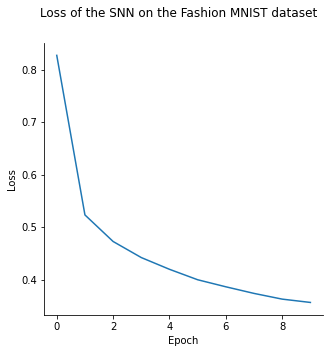

In [17]:
snn.plot_loss(loss,
              title='Loss of the SNN on the Fashion MNIST dataset')

Predict the output on a single batch of the test dataset.

In [18]:
x_batch, y_batch = snn.get_mini_batch(x_test, y_test)
output, [mem_hid, spk_hid] = snn.predict(x_batch.to_dense())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:103: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Depreca

Plot the HIDDEN layer's membrane traces.

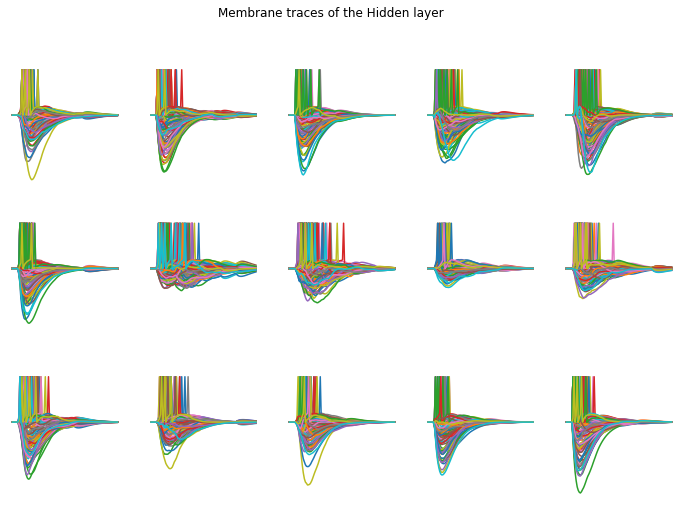

In [19]:
snn.plot_voltage_traces(mem_hid, spk_hid,
                        title='Membrane traces of the Hidden layer')

Plot the READOUT layer's membrane traces.

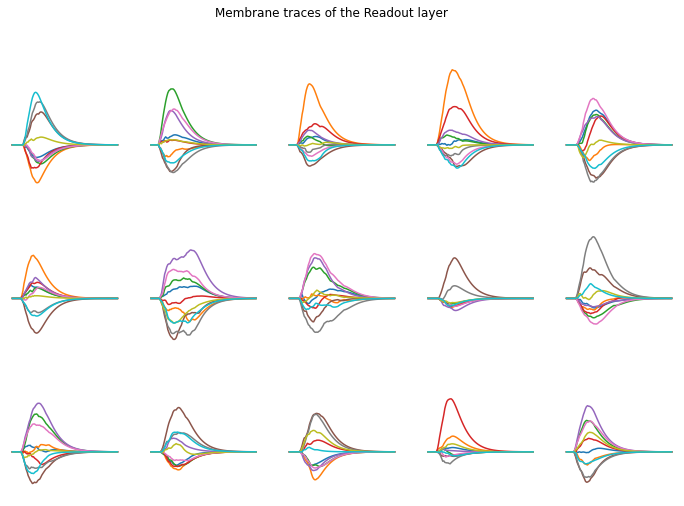

In [20]:
snn.plot_voltage_traces(output,
                        title='Membrane traces of the Readout layer')

Let's plot the HIDDEN layer's spiking activity for some input stimuli.

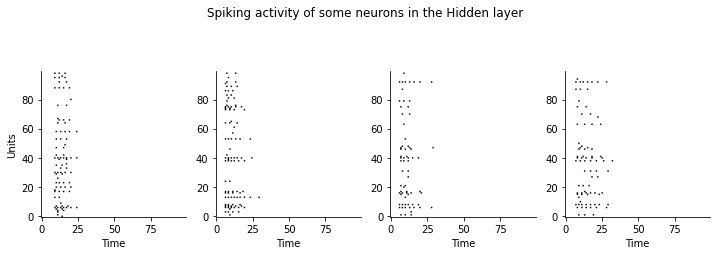

In [21]:
nb_plt = 4
gs = GridSpec(1, nb_plt)
fig = plt.figure(figsize=(12, 4))
fig.suptitle('Spiking activity of some neurons in the Hidden layer')
for i in range(nb_plt):
    plt.subplot(gs[i])
    plt.imshow(spk_hid[i].detach().cpu().numpy().T, cmap=plt.cm.gray_r, origin="lower")
    plt.xlabel("Time")
    if i == 0:
        plt.ylabel("Units")
    sns.despine()
plt.show()

In conclusion, we see that already this simple spiking network solves the classification problem with ~85% accuracy on the test set, and there is plenty of room left for tweaking. However, the hidden layer activities do not look very biological.

Although the network displays population sparseness in that only a subset of neurons are active at any given time, the individual neurons' firing rates are pathologically high. It is not too surprising since we have not incentivized low activity levels in any way. We could address this issue by adding an activity regularization in the network, but this is out of the scope of these tutorials.


---


# References & End Notes

This notebook is based on the work of Friedemann Zenke, with some changes on both code and text. Give a look at this [repository](https://github.com/fzenke/spytorch) for more tutorials on training SNNs with surrogate gradient. If you want to know more on surrogate gradient learning, give a look at this [paper](https://ieeexplore.ieee.org/document/8891809).
